In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import arff
import scipy
import pandas as pd
import os
from sklearn.feature_selection import RFECV
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn import preprocessing
from scipy.stats import bootstrap
import bootstrapped.bootstrap as bs
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import chi2
from sklearn.metrics import roc_curve, roc_auc_score, auc, confusion_matrix, f1_score
import bootstrapped.stats_functions as bs_stats
import warnings
warnings.filterwarnings("ignore")
import statsmodels.api as sm
from imblearn.over_sampling import SMOTE
import itertools
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn import metrics

In [2]:
dataset_links = []
directory = "../data/AReM/"
 
for root, dirs, files in os.walk(directory):
    for file in files:
        if file.endswith('.csv'):
            path = str(root) + '/' + str(file)
            dataset_links.append(path)

In [3]:
train_set_links = []
test_set_links = []
train_data = pd.DataFrame()
test_data = pd.DataFrame()
for link in dataset_links:
    df = pd.read_csv(link, skiprows = 4, usecols=range(0,7))
    if (link.split('/')[-2] == 'bending1' or link.split('/')[-2] == 'bending2'):
        if (link.split('/')[-1] == 'dataset1.csv' or link.split('/')[-1] == 'dataset2.csv'):
            test_set_links.append(link)
            test_data = pd.concat([test_data, df])
        else:
            train_set_links.append(link)
            train_data = pd.concat([train_data, df])
    else:
        if(link.split('/')[-1] == 'dataset1.csv' or 
           link.split('/')[-1] == 'dataset2.csv' or 
           link.split('/')[-1] == 'dataset3.csv'):
            test_set_links.append(link)
            test_data = pd.concat([test_data, df])
        else:
            train_set_links.append(link)
            train_data = pd.concat([train_data, df])

In [4]:
features = ['mean', 'median', 'std']
col = ['avg_rss12', 'var_rss12', 'var_rss23']
ts_df = pd.DataFrame()
ts_features = pd.DataFrame()
for i in range(len(train_set_links)):
    ts_df = pd.read_csv(train_set_links[i], skiprows = 4, on_bad_lines='skip')
    
    if ('bending' in train_set_links[i]):
        ts_features.at[i, 'activity'] = 'bending'
    else:
        ts_features.at[i, 'activity'] = 'other'
        
    for j in range(len(col)):
        for k in range(len(features)):
            if (k == 0):
                column = col[j] + '-' + features[k]
                if (i == 0):
                    ts_features[column] = [ts_df[col[j]].mean()]
                else:
                    ts_features.at[i, column] = ts_df[col[j]].mean()
            elif (k == 1):
                column = col[j] + '-' + features[k]
                if (i == 0):
                    ts_features[column] = [ts_df[col[j]].median()]
                else:
                    ts_features.at[i, column] = ts_df[col[j]].median()
            else:
                column = col[j] + '-' + features[k]
                if (i == 0):
                    ts_features[column] = [ts_df[col[j]].std()]
                else:
                    ts_features.at[i, column] = ts_df[col[j]].std()
ts_features

,activity,avg_rss12-mean,avg_rss12-median,avg_rss12-std,var_rss12-mean,var_rss12-median,var_rss12-std,var_rss23-mean,var_rss23-median,var_rss23-std
0,bending,43.954500,44.330,1.558835,0.426250,0.470,0.338690,0.493292,0.430,0.513506
1,bending,42.179813,43.500,3.670666,0.696042,0.500,0.630860,0.613521,0.500,0.524317
2,bending,41.678063,41.750,2.243490,0.535979,0.500,0.405469,0.383292,0.430,0.389164
3,bending,43.454958,43.250,1.386098,0.378083,0.470,0.315566,0.679646,0.500,0.622534
4,bending,43.969125,44.500,1.618364,0.413125,0.470,0.263111,0.555313,0.490,0.487826
...,...,...,...,...,...,...,...,...,...,...
64,other,34.763333,35.290,4.742208,4.223792,3.900,2.278004,3.288271,3.270,1.647528
65,other,34.935813,35.500,4.645944,4.115750,3.845,2.335243,3.280021,3.015,1.700918
66,other,34.333042,34.750,4.948770,4.396958,3.900,2.568680,3.261583,2.980,1.617290
67,other,34.599875,35.125,4.731790,4.398833,4.025,2.538521,3.289542,3.015,1.680170


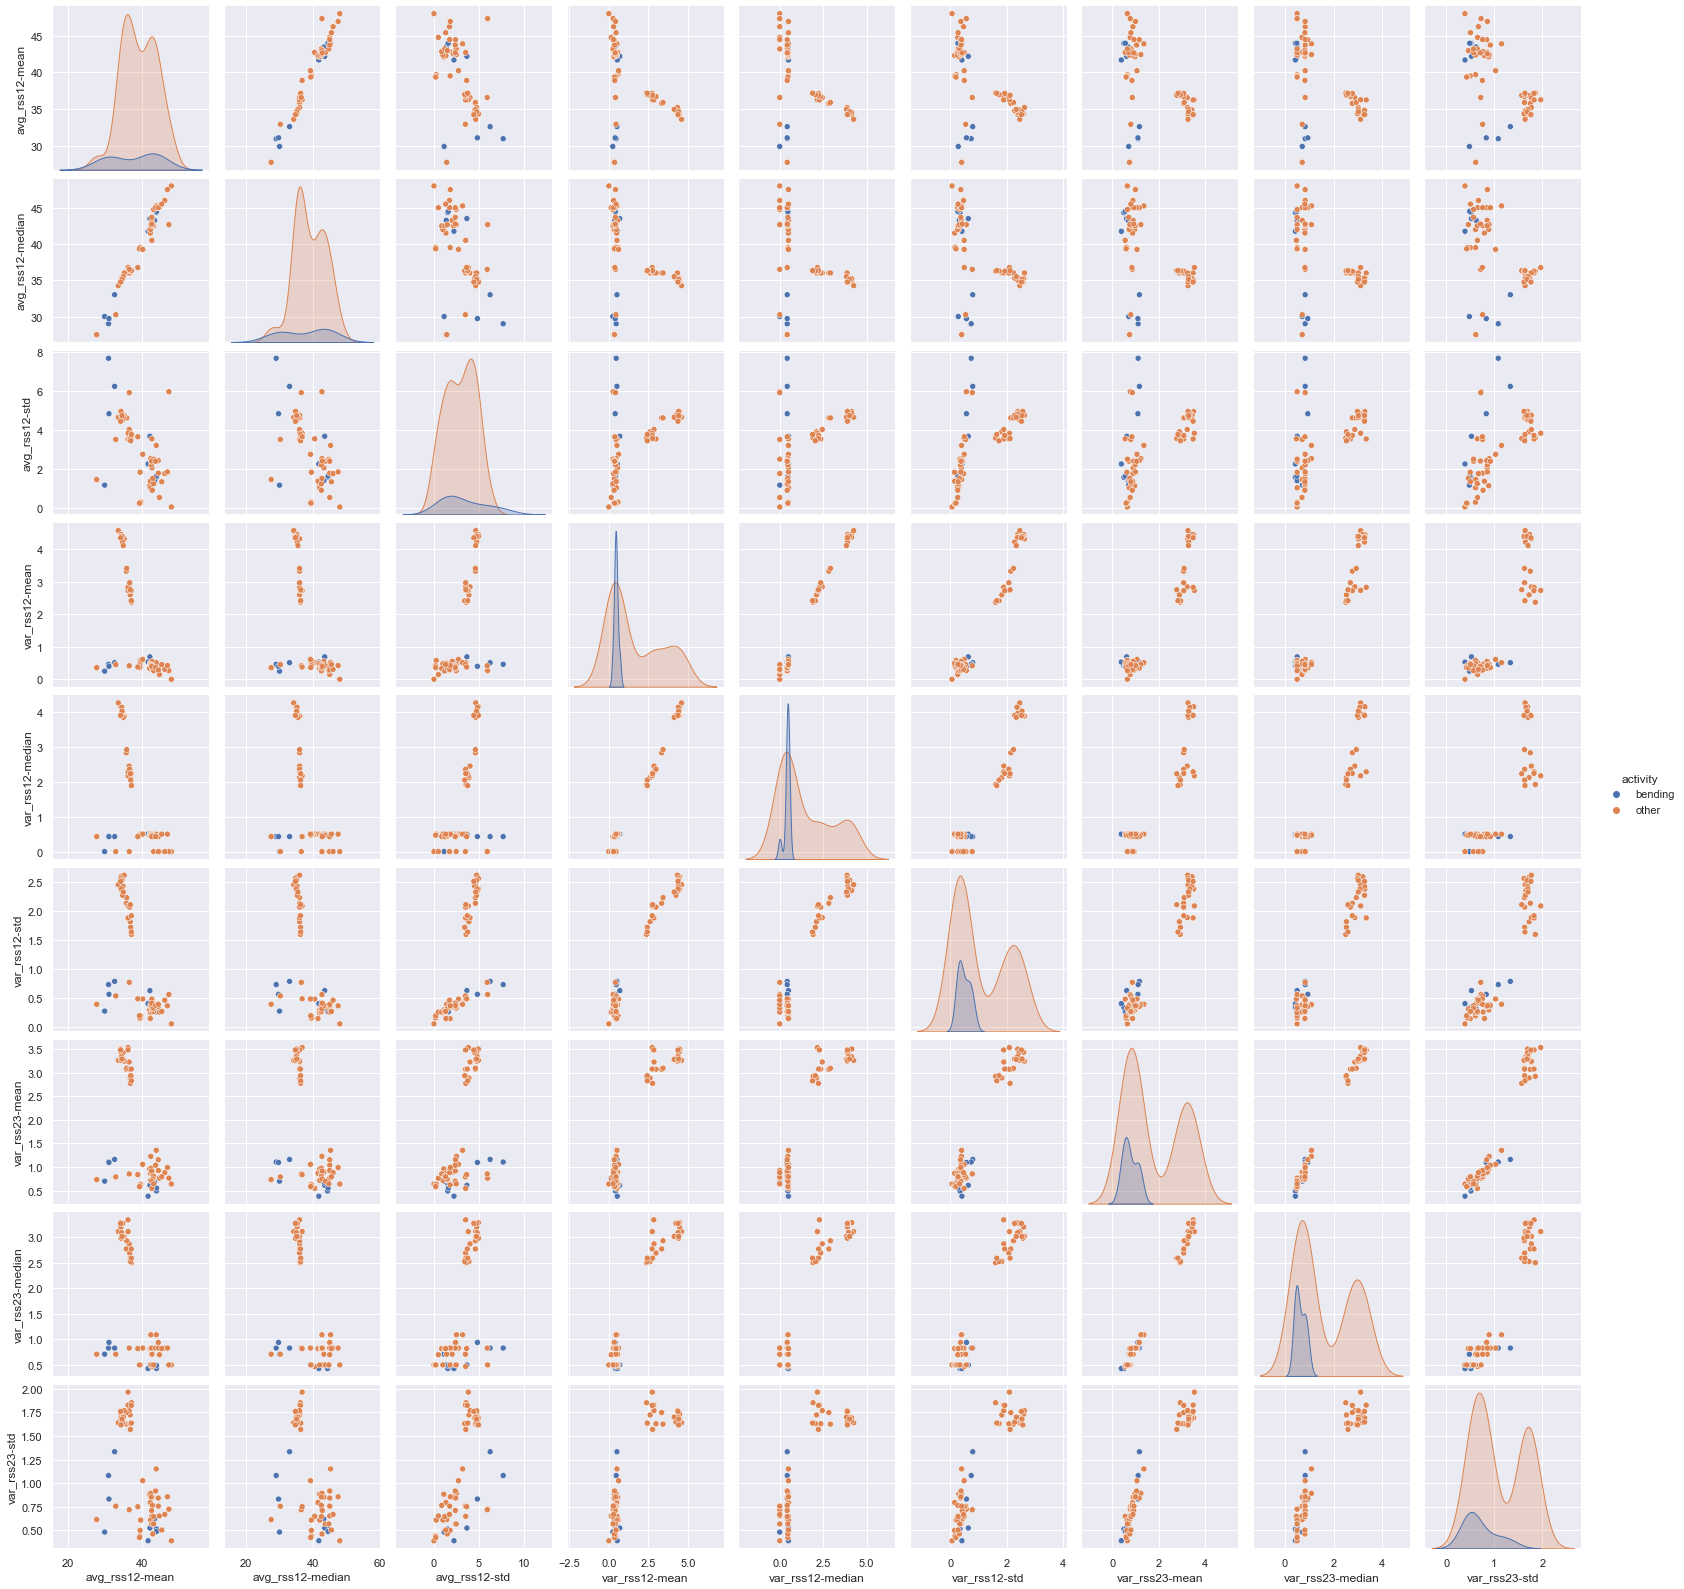

In [5]:
sns.set()
sns.pairplot(ts_features, hue = 'activity', kind = 'scatter')

In [6]:
def data_split(dataframe, partitions):
    df1 = {}
    length = dataframe.shape[0]
    for i in range(1, dataframe.shape[1]): 
        for j in range(partitions):
            column = dataframe.columns[i] + '_' + str(j+1)
            df1[column] = dataframe.iloc[j*(length//partitions):(j+1)*(length//partitions), i].values
    df2 = pd.DataFrame(df1)
    
    return df2

df2 = data_split(train_data, 2)
df2

,avg_rss12_1,avg_rss12_2,var_rss12_1,var_rss12_2,avg_rss13_1,avg_rss13_2,var_rss13_1,var_rss13_2,avg_rss23_1,avg_rss23_2,var_rss23_1,var_rss23_2
0,42.00,47.00,0.71,0.00,21.25,13.67,0.43,0.47,30.00,18.67,0.00,2.62
1,41.50,46.75,0.50,0.43,20.25,17.25,1.48,1.79,31.25,18.25,1.09,2.77
2,41.50,46.50,0.50,0.50,14.25,20.00,1.92,1.22,33.00,19.75,0.00,1.30
3,40.75,46.75,0.83,0.43,15.75,18.75,0.43,0.83,33.00,16.75,0.00,1.09
4,40.00,46.75,0.71,0.43,20.00,19.25,2.74,1.30,32.75,19.75,0.43,1.09
...,...,...,...,...,...,...,...,...,...,...,...,...
16554,46.67,37.25,0.47,7.26,22.00,14.00,0.00,1.58,23.25,13.25,0.83,4.92
16555,46.50,31.50,0.50,1.66,21.75,12.50,0.43,3.20,22.75,14.25,0.83,4.44
16556,46.50,27.33,0.50,1.25,21.00,11.33,0.00,0.94,22.50,20.00,1.12,4.00
16557,46.75,37.80,0.43,7.68,19.50,14.20,0.87,2.48,23.00,17.25,0.71,0.83


In [7]:
def splitting_function(links, partitions):
    features = ['mean', 'median', 'std']
    col = ['avg_rss12', 'var_rss12', 'var_rss23']
    ts_df = pd.DataFrame()
    ts_features = pd.DataFrame()
    for i in range(len(links)):
        ts_df = pd.read_csv(links[i], skiprows = 4, on_bad_lines='skip')
        length = ts_df.shape[0]
        if ('bending' in train_set_links[i]):
            ts_features.at[i, 'activity'] = 'bending'
        else:
            ts_features.at[i, 'activity'] = 'other'

        for j in range(len(col)):
            for k in range(len(features)):
                for l in range(partitions):
                    if (k == 0):
                        column = col[j] + '-' + features[k] + '_' + str(l+1)
                        if (i == 0):
                            ts_features[column] = [ts_df[col[j]][l*(length//partitions): (l+1)*(length//partitions)].mean()]
                        else:
                            ts_features.at[i, column] = ts_df[col[j]][l*(length//partitions): (l+1)*(length//partitions)].mean()
                    elif (k == 1):
                        column = col[j] + '-' + features[k] + '_' + str(l+1)
                        if (i == 0):
                            ts_features[column] = [ts_df[col[j]][l*(length//partitions): (l+1)*(length//partitions)].median()]
                        else:
                            ts_features.at[i, column] = ts_df[col[j]][l*(length//partitions): (l+1)*(length//partitions)].median()
                    else:
                        column = col[j] + '-' + features[k] + '_' + str(l+1)
                        if (i == 0):
                            ts_features[column] = [ts_df[col[j]][l*(length//partitions): (l+1)*(length//partitions)].std()]
                        else:
                            ts_features.at[i, column] = ts_df[col[j]][l*(length//partitions): (l+1)*(length//partitions)].std()

    return ts_features
    
df = splitting_function(train_set_links, 2)
df

,activity,avg_rss12-mean_1,avg_rss12-mean_2,avg_rss12-median_1,avg_rss12-median_2,avg_rss12-std_1,avg_rss12-std_2,var_rss12-mean_1,var_rss12-mean_2,var_rss12-median_1,var_rss12-median_2,var_rss12-std_1,var_rss12-std_2,var_rss23-mean_1,var_rss23-mean_2,var_rss23-median_1,var_rss23-median_2,var_rss23-std_1,var_rss23-std_2
0,bending,44.057167,43.851833,44.500,43.500,1.556971,1.557168,0.381042,0.471458,0.470,0.500,0.329540,0.342346,0.598250,0.388333,0.500,0.000,0.526656,0.478528
1,bending,43.278875,41.080750,45.000,42.000,3.473355,3.537481,0.673292,0.718792,0.485,0.500,0.634285,0.627915,0.640958,0.586083,0.765,0.470,0.554542,0.491873
2,bending,41.621208,41.734917,42.330,41.500,3.118644,0.595920,0.623083,0.448875,0.500,0.500,0.489595,0.273050,0.419083,0.347500,0.430,0.430,0.411200,0.363144
3,bending,44.117042,42.792875,45.000,42.670,1.359836,1.058792,0.250042,0.506125,0.000,0.500,0.314099,0.260761,0.815417,0.543875,0.710,0.500,0.718016,0.473445
4,bending,43.486208,44.452042,43.710,44.500,1.281976,1.771251,0.378667,0.447583,0.470,0.500,0.284434,0.235493,0.524875,0.585750,0.470,0.500,0.486847,0.487918
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,other,34.966250,34.560417,35.500,35.000,4.733014,4.752584,4.207958,4.239625,3.900,3.960,2.331940,2.227526,3.146333,3.430208,3.035,3.350,1.638218,1.647979
65,other,34.737042,35.134583,35.500,35.585,4.276717,4.989014,4.217333,4.014167,4.030,3.670,2.337759,2.333172,3.334125,3.225917,3.000,3.085,1.737573,1.665326
66,other,33.886458,34.779625,34.375,35.000,5.143776,4.714249,4.332208,4.461708,3.900,3.935,2.453111,2.682846,3.248417,3.274750,3.015,2.955,1.565557,1.670593
67,other,34.836458,34.363292,35.750,35.000,4.869092,4.588342,4.257750,4.539917,3.770,4.075,2.512633,2.561608,3.169625,3.409458,2.870,3.110,1.647640,1.707089


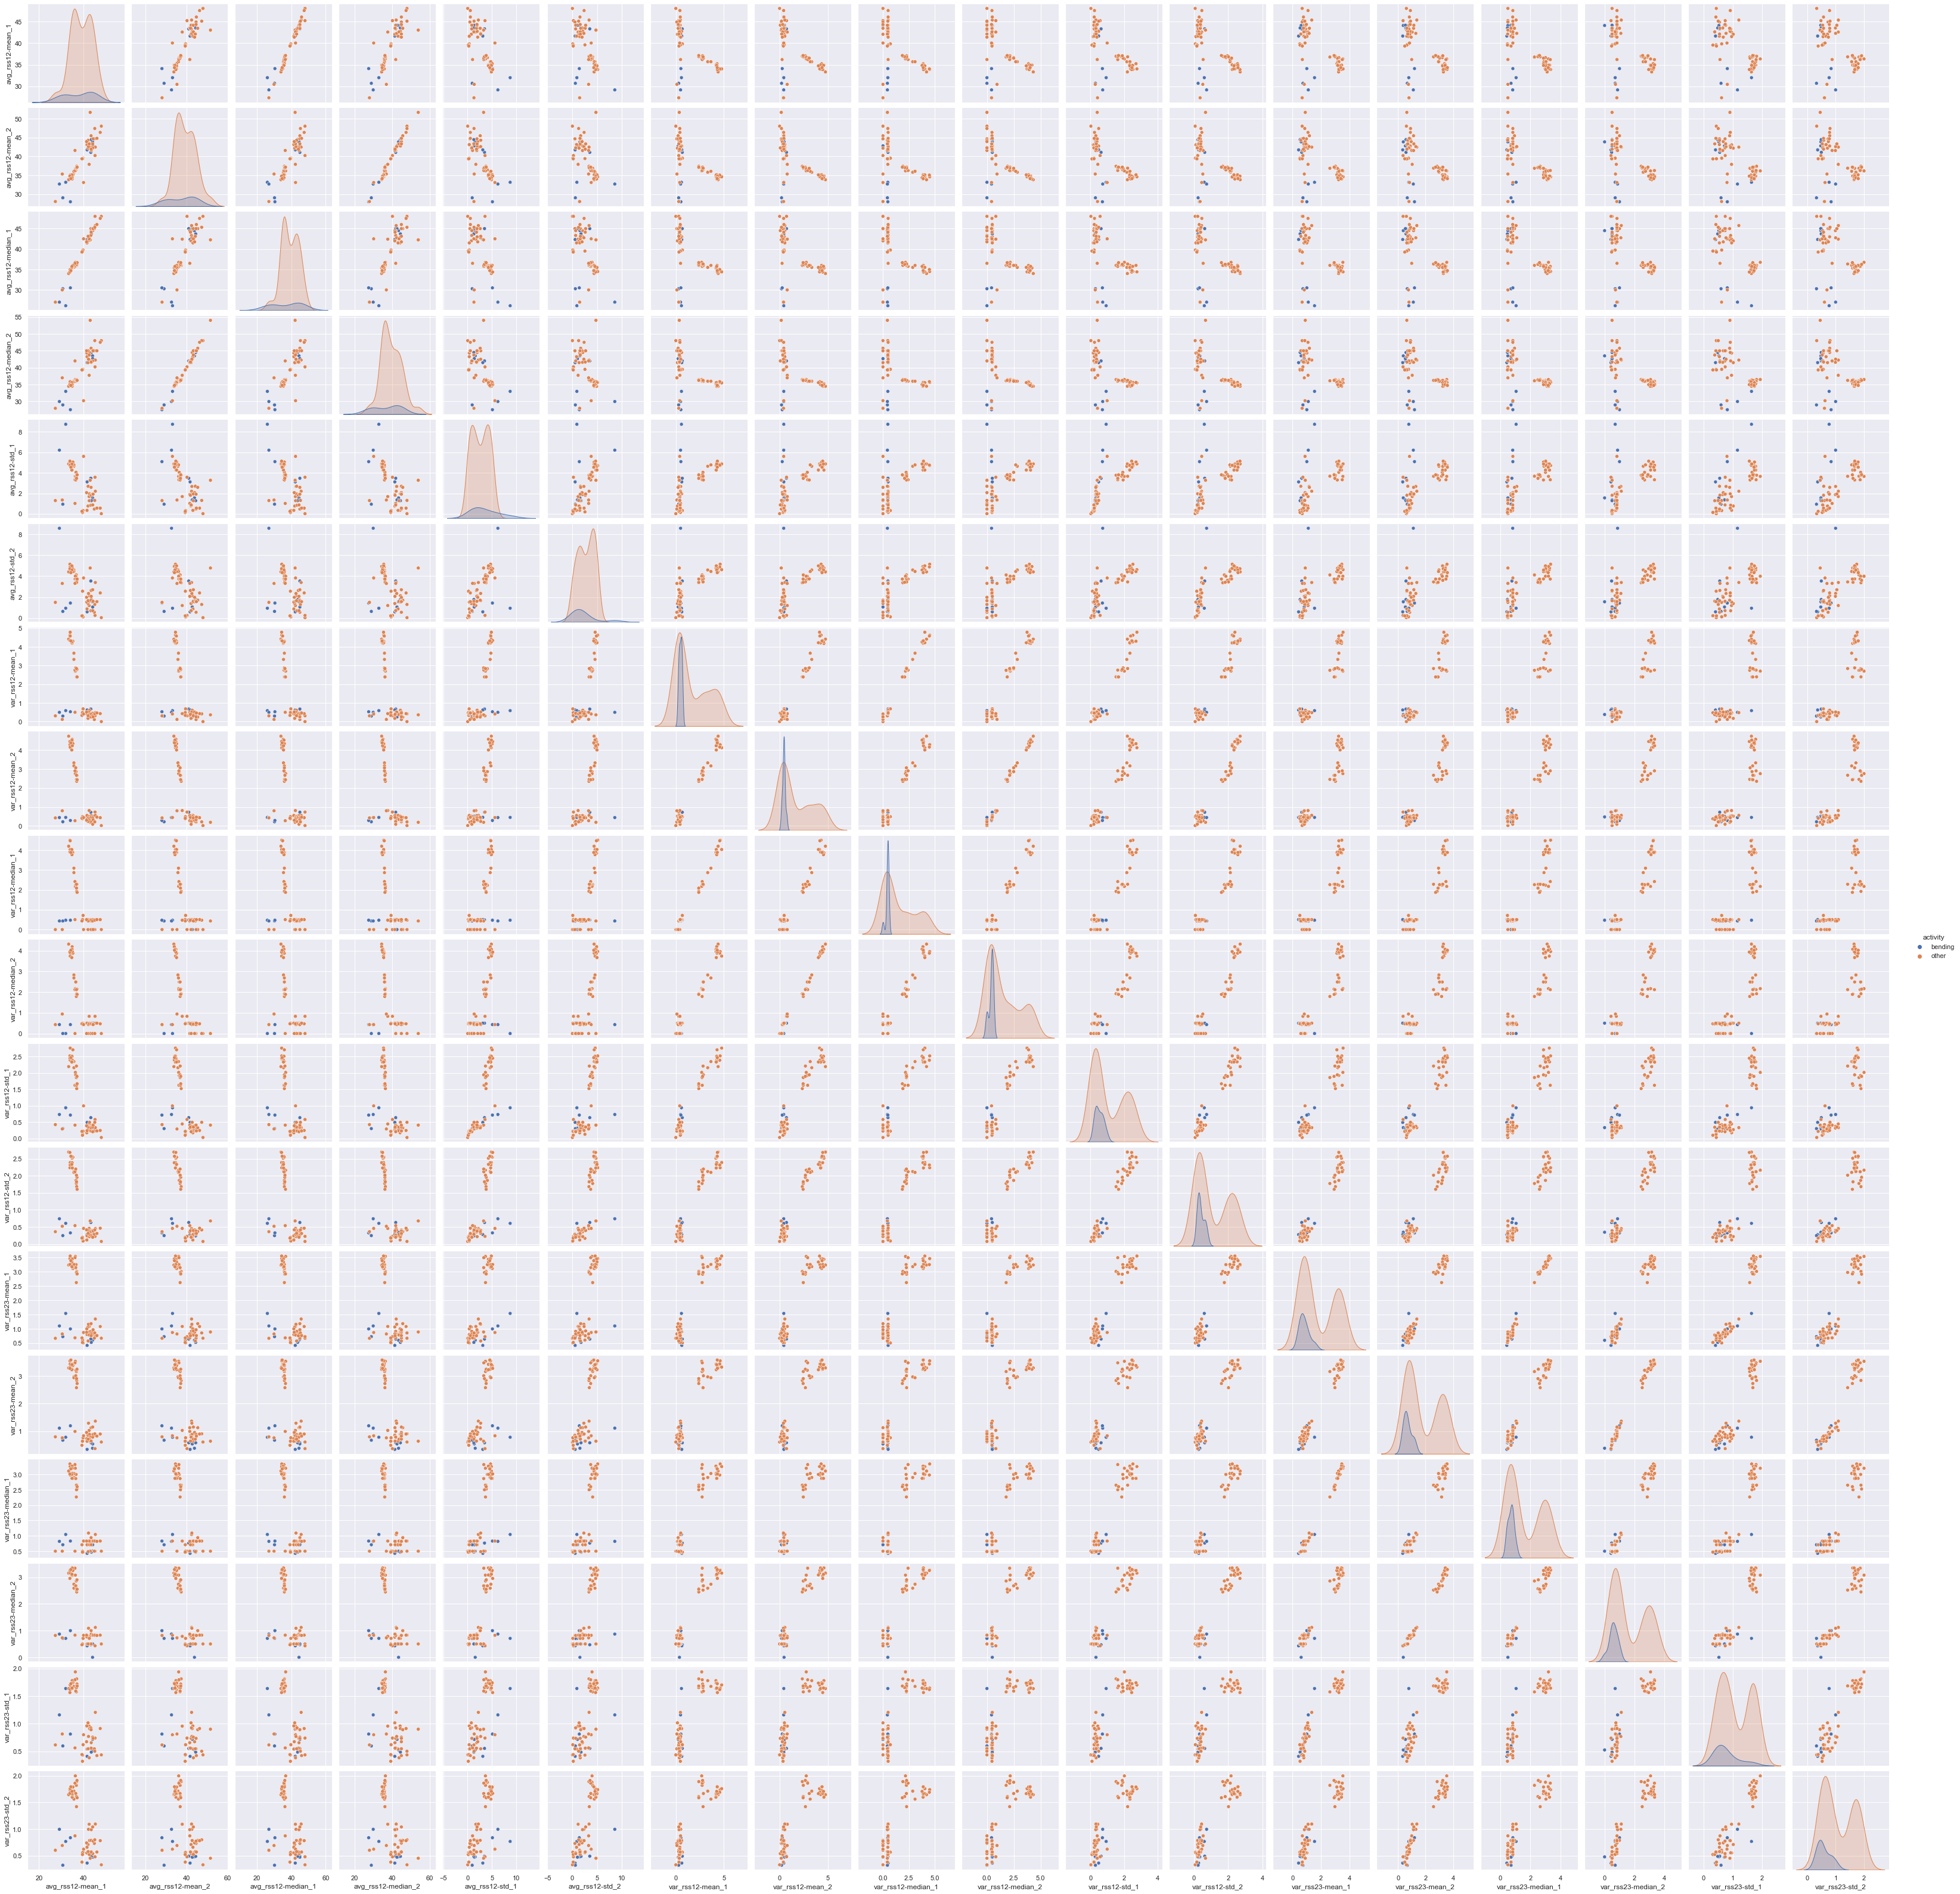

In [8]:
sns.pairplot(df, hue = 'activity', kind = 'scatter')

#### By looking at both results, we observe that the class seperations look the same for bending vs other activities. But, corelations have changed a bit.

In [9]:
l_val = 0
best_accuracy = float("-inf")
best_features = []

for l in range(1, 21):
    new_data = splitting_function(train_set_links, l)
    X = new_data.iloc[: , 1:]
    y = new_data.iloc[: , 0]
    encode = preprocessing.LabelEncoder()
    encode.fit(y)
    y = encode.transform(y).ravel()
    logistic_regressor = LogisticRegression(penalty="none", max_iter=25)
    rfecv = RFECV(estimator = logistic_regressor, step = 1, cv = StratifiedKFold(n_splits=5))
    rfecv = rfecv.fit(X, y)
    print('-------------------------------------------------------------------------------')
    print("For l:", l)
    print("Count of best features:", rfecv.n_features_)
    pruned_X = X[X.columns[rfecv.support_]]
    logistic_regressor.fit(pruned_X, y)
    predictions = logistic_regressor.predict(pruned_X)
    accuracy = accuracy_score(predictions, y)
    print("Accuracy (with pruned features) is:", accuracy)
    if best_accuracy < accuracy:
        best_accuracy = accuracy
        l_val = l   
        best_features =  X.columns[rfecv.support_]

-------------------------------------------------------------------------------
For l: 1
Count of best features: 1
Accuracy (with pruned features) is: 0.8695652173913043
-------------------------------------------------------------------------------
For l: 2
Count of best features: 14
Accuracy (with pruned features) is: 0.927536231884058
-------------------------------------------------------------------------------
For l: 3
Count of best features: 8
Accuracy (with pruned features) is: 0.9565217391304348
-------------------------------------------------------------------------------
For l: 4
Count of best features: 17
Accuracy (with pruned features) is: 0.8840579710144928
-------------------------------------------------------------------------------
For l: 5
Count of best features: 24
Accuracy (with pruned features) is: 0.9420289855072463
-------------------------------------------------------------------------------
For l: 6
Count of best features: 52
Accuracy (with pruned features) 

In [10]:
print("Selecting the smallest l, if multiple models have the highest cross-validation accuracy\n")
print("The best accuracy achieved is: ", best_accuracy)
print("It is first achieved at l:", l_val, "and p:", len(best_features))
print("\nThe features used to achieve this accuracy: \n", best_features)

Selecting the smallest l, if multiple models have the highest cross-validation accuracy

The best accuracy achieved is:  1.0
It is first achieved at l: 8 and p: 12

The features used to achieve this accuracy: 
 Index(['avg_rss12-std_2', 'var_rss12-mean_3', 'var_rss12-mean_4',
       'var_rss12-mean_7', 'var_rss12-median_3', 'var_rss12-median_4',
       'var_rss12-median_7', 'var_rss23-mean_6', 'var_rss23-median_1',
       'var_rss23-median_6', 'var_rss23-median_8', 'var_rss23-std_6'],
      dtype='object')


#### The correct way to perform cross validation is by doing it on the complete set of the parameters (before pruning the parameters). We should do feature selection while performing cross validation.

The confusion matrix:
 [[ 9  0]
 [ 0 60]]


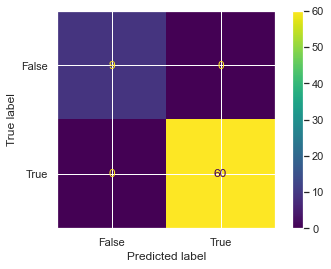

In [11]:
new_data = splitting_function(train_set_links, l_val)
train_X = new_data.iloc[: , 1:]
train_X = train_X[best_features]
train_y = new_data.iloc[: , 0]
encode = preprocessing.LabelEncoder()
encode.fit(train_y)
train_y = encode.transform(train_y).ravel()
logistic_regressor = LogisticRegression(penalty="none", max_iter=25)
logistic_regressor.fit(train_X, train_y)
predictions = logistic_regressor.predict(train_X)
c_matrix = confusion_matrix(train_y, predictions)
print("The confusion matrix:\n", c_matrix)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = c_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

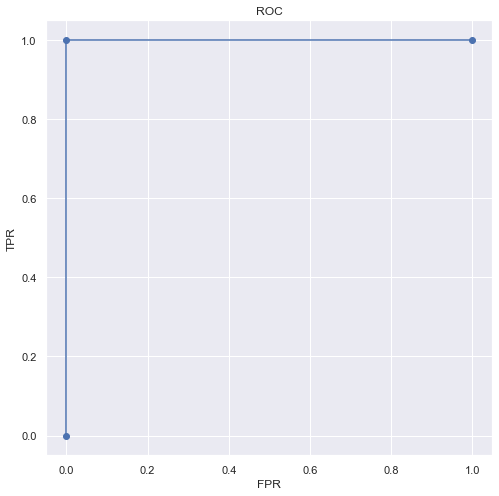

In [12]:
FPR, TPR, _ = roc_curve(train_y, predictions)
plt.figure(figsize=(8,8))
plt.plot(FPR, TPR, marker='o')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title("ROC")
plt.show()

In [13]:
AUC = roc_auc_score(train_y, predictions)
print('AUC score:', AUC)

AUC score: 1.0


In [14]:
smlogistic_regressor = sm.Logit(train_y, train_X).fit(logistic_regressor='bfgs', maxiter=25)
print(smlogistic_regressor.summary())

Optimization terminated successfully.
         Current function value: 0.111898
         Iterations 11
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                   69
Model:                          Logit   Df Residuals:                       57
Method:                           MLE   Df Model:                           11
Date:                Tue, 18 Oct 2022   Pseudo R-squ.:                  0.7110
Time:                        12:12:17   Log-Likelihood:                -7.7209
converged:                       True   LL-Null:                       -26.718
Covariance Type:            nonrobust   LLR p-value:                 7.844e-05
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
avg_rss12-std_2       -1.6973      0.835     -2.033      0.042      -3.334      -0.061
var_

In [15]:
new_data = splitting_function(test_set_links, l_val)
test_X = new_data.iloc[: , 1:]
test_X = test_X[best_features]
test_y = new_data.iloc[: , 0]
encode = preprocessing.LabelEncoder()
encode.fit(test_y)
test_y = encode.transform(test_y).ravel()
logistic_regressor = LogisticRegression(penalty="none", max_iter=25)
logistic_regressor.fit(test_X, test_y)
predictions = logistic_regressor.predict(test_X)
accuracy = accuracy_score(predictions, test_y)
print("Test Accuracy: ", accuracy)
print("Train Accuracy: ", best_accuracy)
print("The cross validation and test accuracy are same, that is: 1.0")

Test Accuracy:  1.0
Train Accuracy:  1.0
The cross validation and test accuracy are same, that is: 1.0


The confusion matrix:
 [[60  0]
 [ 1 59]]


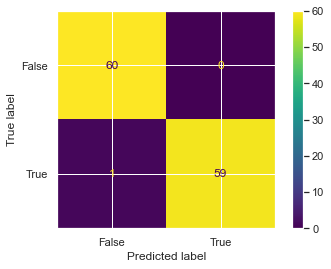


Imbalanced classes observed.


In [16]:
smote = SMOTE(random_state = 42)
X1, y1 = smote.fit_resample(train_X, train_y)
logistic_regressor = LogisticRegression(penalty="none", max_iter=25)
logistic_regressor.fit(X1,y1)
predictions = logistic_regressor.predict(X1)
probability = logistic_regressor.predict_proba(X1)[:,1]
c_matrix = confusion_matrix(y1, predictions)
print("The confusion matrix:\n", c_matrix)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = c_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()
print("\nImbalanced classes observed.")

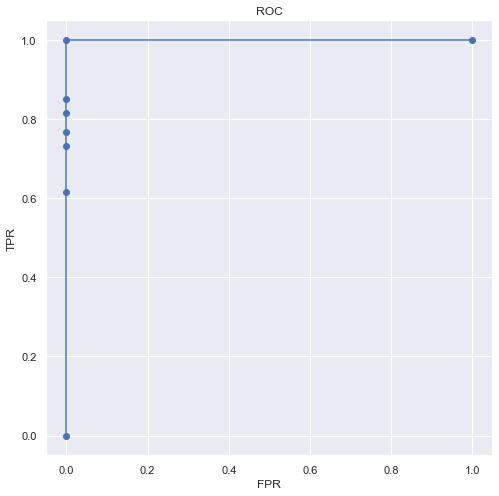

In [17]:
FPR, TPR, _ = roc_curve(y1, probability)
plt.figure(figsize=(8,8))
plt.plot(FPR, TPR, marker='o')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title("ROC")
plt.show()

In [18]:
AUC = roc_auc_score(y1, predictions)
print('AUC score:', AUC)

AUC score: 0.9916666666666667


In [19]:
l_val = 0
best_accuracy = float("-inf")
best_features = []
for l in range(1, 21):
    new_data = splitting_function(train_set_links, l)
    X = new_data.iloc[: , 1:]
    X = (X-X.mean())/X.std()
    y = new_data.iloc[: , 0]
    encode = preprocessing.LabelEncoder()
    encode.fit(y)
    y = encode.transform(y).ravel()
    logistic_regressor = LogisticRegression(penalty="l1", max_iter=25, solver = 'liblinear')
    rfecv = RFECV(estimator = logistic_regressor, step = 2, cv = StratifiedKFold(n_splits=5))
    rfecv = rfecv.fit(X, y)
    print('-------------------------------------------------------------------------------')
    print("l: ", l)
    print("Best features Count: ", rfecv.n_features_)
    pruned_X = X[X.columns[rfecv.support_]]
    logistic_regressor.fit(pruned_X, y)
    predictions = logistic_regressor.predict(pruned_X)
    accuracy = accuracy_score(predictions, y)
    print("Accuracy: ", accuracy)   
    if best_accuracy < accuracy:
        best_accuracy = accuracy
        l_val = l   
        best_features =  X.columns[rfecv.support_]

-------------------------------------------------------------------------------
l:  1
Best features Count:  1
Accuracy:  0.8695652173913043
-------------------------------------------------------------------------------
l:  2
Best features Count:  2
Accuracy:  0.8840579710144928
-------------------------------------------------------------------------------
l:  3
Best features Count:  3
Accuracy:  0.8985507246376812
-------------------------------------------------------------------------------
l:  4
Best features Count:  1
Accuracy:  0.8695652173913043
-------------------------------------------------------------------------------
l:  5
Best features Count:  5
Accuracy:  0.9420289855072463
-------------------------------------------------------------------------------
l:  6
Best features Count:  1
Accuracy:  0.8695652173913043
-------------------------------------------------------------------------------
l:  7
Best features Count:  1
Accuracy:  0.8695652173913043
--------------------

In [20]:
print("The best accuracy achieved is: ", best_accuracy)
print("It is achieved at l:", l_val, "and p:", len(best_features))
print("\nThe features used to achieve this accuracy: \n", best_features)

The best accuracy achieved is:  0.9420289855072463
It is achieved at l: 5 and p: 5

The features used to achieve this accuracy: 
 Index(['avg_rss12-median_2', 'avg_rss12-median_4', 'avg_rss12-std_1',
       'avg_rss12-std_2', 'var_rss23-std_4'],
      dtype='object')


In [21]:
new_data = splitting_function(test_set_links, l_val)
test_X = new_data.iloc[: , 1:]
test_X = test_X[best_features]
test_y = new_data.iloc[: , 0]
encode = preprocessing.LabelEncoder()
encode.fit(test_y)
test_y = encode.transform(test_y).ravel()
logistic_regressor = LogisticRegression(penalty="l1", max_iter=25, solver = 'liblinear')
logistic_regressor.fit(test_X, test_y)
predictions = logistic_regressor.predict(test_X)
accuracy = accuracy_score(predictions, test_y)
print("Test Accuracy: ", accuracy)
print("Train Accuracy: ", best_accuracy)

Test Accuracy:  0.631578947368421
Train Accuracy:  0.9420289855072463


In [22]:
print("Test accuracy of Logistic Regression (RFECV with stratified CV) is: 1.0")
print("Test accuracy of L1-penalized Logistic Regression is:", accuracy)

Test accuracy of Logistic Regression (RFECV with stratified CV) is: 1.0
Test accuracy of L1-penalized Logistic Regression is: 0.631578947368421


#### The L1-penalized with recursive feature elimination method performs better. It also took less time and is easier to implement. 

In [23]:
def multiclass_splitting_function(links, partitions):
    features = ['mean', 'median', 'std']
    col = ['avg_rss12', 'var_rss12', 'var_rss23']
    ts_df = pd.DataFrame()
    ts_features = pd.DataFrame()
    for i in range(len(links)):
        ts_df = pd.read_csv(links[i], skiprows = 4, on_bad_lines='skip')
        length = ts_df.shape[0]
        if ('bending' in links[i]):
            ts_features.at[i, 'activity'] = 0
        else:
            if ('cycling' in links[i]):
                ts_features.at[i, 'activity'] = 1
            elif ('lying' in links[i]):
                ts_features.at[i, 'activity'] = 2
            elif ('sitting' in links[i]):
                ts_features.at[i, 'activity'] = 3
            elif ('standing' in links[i]):
                ts_features.at[i, 'activity'] = 4
            elif ('walking' in links[i]):
                ts_features.at[i, 'activity'] = 5
                

        for j in range(len(col)):
            for k in range(len(features)):
                for l in range(partitions):
                    if (k == 0):
                        column = col[j] + '-' + features[k] + '_' + str(l+1)
                        if (i == 0):
                            ts_features[column] = [ts_df[col[j]][l*(length//partitions): (l+1)*(length//partitions)].mean()]
                        else:
                            ts_features.at[i, column] = ts_df[col[j]][l*(length//partitions): (l+1)*(length//partitions)].mean()
                    elif (k == 1):
                        column = col[j] + '-' + features[k] + '_' + str(l+1)
                        if (i == 0):
                            ts_features[column] = [ts_df[col[j]][l*(length//partitions): (l+1)*(length//partitions)].median()]
                        else:
                            ts_features.at[i, column] = ts_df[col[j]][l*(length//partitions): (l+1)*(length//partitions)].median()
                    else:
                        column = col[j] + '-' + features[k] + '_' + str(l+1)
                        if (i == 0):
                            ts_features[column] = [ts_df[col[j]][l*(length//partitions): (l+1)*(length//partitions)].std()]
                        else:
                            ts_features.at[i, column] = ts_df[col[j]][l*(length//partitions): (l+1)*(length//partitions)].std()

    return ts_features
    
multi_df = multiclass_splitting_function(train_set_links, 1)
multi_df

,activity,avg_rss12-mean_1,avg_rss12-median_1,avg_rss12-std_1,var_rss12-mean_1,var_rss12-median_1,var_rss12-std_1,var_rss23-mean_1,var_rss23-median_1,var_rss23-std_1
0,0.0,43.954500,44.330,1.558835,0.426250,0.470,0.338690,0.493292,0.430,0.513506
1,0.0,42.179813,43.500,3.670666,0.696042,0.500,0.630860,0.613521,0.500,0.524317
2,0.0,41.678063,41.750,2.243490,0.535979,0.500,0.405469,0.383292,0.430,0.389164
3,0.0,43.454958,43.250,1.386098,0.378083,0.470,0.315566,0.679646,0.500,0.622534
4,0.0,43.969125,44.500,1.618364,0.413125,0.470,0.263111,0.555313,0.490,0.487826
...,...,...,...,...,...,...,...,...,...,...
64,5.0,34.763333,35.290,4.742208,4.223792,3.900,2.278004,3.288271,3.270,1.647528
65,5.0,34.935813,35.500,4.645944,4.115750,3.845,2.335243,3.280021,3.015,1.700918
66,5.0,34.333042,34.750,4.948770,4.396958,3.900,2.568680,3.261583,2.980,1.617290
67,5.0,34.599875,35.125,4.731790,4.398833,4.025,2.538521,3.289542,3.015,1.680170


In [24]:
l_val = 0
best_accuracy = float("-inf")
best_features = []
for l in range(1, 21):
    new_data = multiclass_splitting_function(train_set_links, l)
    X = new_data.iloc[: , 1:]
    X = (X-X.mean())/X.std()
    y = new_data.iloc[: , 0]
    encode = preprocessing.LabelEncoder()
    encode.fit(y)
    y = encode.transform(y).ravel()
    logistic_regressor = LogisticRegression(penalty="l1", max_iter=25, solver = 'liblinear')
    rfecv = RFECV(estimator = logistic_regressor, step = 2, cv = StratifiedKFold(n_splits=5))
    rfecv = rfecv.fit(X, y)
    print('-------------------------------------------------------------------------------')
    print("l: ", l)
    print("Best features Count: ", rfecv.n_features_)
    pruned_X = X[X.columns[rfecv.support_]]
    logistic_regressor.fit(pruned_X, y)
    predictions = logistic_regressor.predict(pruned_X)
    accuracy = accuracy_score(predictions, y)
    print("Accuracy: ", accuracy)       
    if best_accuracy <= accuracy:
        best_accuracy = accuracy
        l_val = l   
        best_features =  X.columns[rfecv.support_]     

-------------------------------------------------------------------------------
l:  1
Best features Count:  7
Accuracy:  0.7101449275362319
-------------------------------------------------------------------------------
l:  2
Best features Count:  10
Accuracy:  0.8115942028985508
-------------------------------------------------------------------------------
l:  3
Best features Count:  13
Accuracy:  0.7971014492753623
-------------------------------------------------------------------------------
l:  4
Best features Count:  6
Accuracy:  0.7246376811594203
-------------------------------------------------------------------------------
l:  5
Best features Count:  17
Accuracy:  0.8695652173913043
-------------------------------------------------------------------------------
l:  6
Best features Count:  14
Accuracy:  0.8695652173913043
-------------------------------------------------------------------------------
l:  7
Best features Count:  11
Accuracy:  0.855072463768116
----------------

In [25]:
print("The best accuracy achieved is: ", best_accuracy)
print("It is achieved at l:", l_val, "and p:", len(best_features))
print("\nThe features used to achieve this accuracy: \n", best_features)

The best accuracy achieved is:  0.9855072463768116
It is achieved at l: 19 and p: 23

The features used to achieve this accuracy: 
 Index(['avg_rss12-median_13', 'avg_rss12-median_19', 'avg_rss12-std_1',
       'avg_rss12-std_4', 'avg_rss12-std_5', 'avg_rss12-std_11',
       'avg_rss12-std_16', 'avg_rss12-std_19', 'var_rss12-median_7',
       'var_rss12-median_13', 'var_rss12-median_14', 'var_rss12-std_6',
       'var_rss23-mean_6', 'var_rss23-median_18', 'var_rss23-std_1',
       'var_rss23-std_2', 'var_rss23-std_3', 'var_rss23-std_4',
       'var_rss23-std_10', 'var_rss23-std_13', 'var_rss23-std_15',
       'var_rss23-std_17', 'var_rss23-std_18'],
      dtype='object')


Train Accuracy :  0.9855072463768116
Confusion Matrix:

[[ 9  0  0  0  0  0]
 [ 0 12  0  0  0  0]
 [ 0  0 11  0  1  0]
 [ 0  0  0 12  0  0]
 [ 0  0  0  0 12  0]
 [ 0  0  0  0  0 12]]


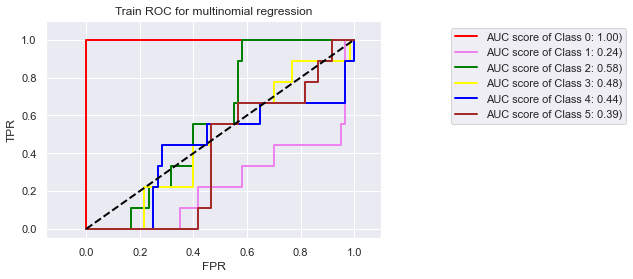

In [26]:
multi_df = multiclass_splitting_function(train_set_links,l_val)
XTrain = multi_df.iloc[: , 1:]
yTrain = multi_df.iloc[: , 0]
XTrain=(XTrain-XTrain.mean())/XTrain.std()
XTrain = XTrain[best_features]
logistic_regressor = LogisticRegression(penalty="l1", max_iter=25, solver = 'liblinear')
logistic_regressor.fit(XTrain, yTrain)
train_pred = logistic_regressor.predict(XTrain)
pred_train_prob = logistic_regressor.predict_proba(XTrain)
accuracy = accuracy_score(train_pred, yTrain)
print("Train Accuracy : ", accuracy)
c_matrix_train = confusion_matrix(yTrain, train_pred)
print("Confusion Matrix:\n")
print(c_matrix_train)
labels = preprocessing.label_binarize(yTrain, classes=[0, 1, 2, 3, 4, 5])
predictions = logistic_regressor.decision_function(XTrain)
values = [0,1,2,3,4,5]
FPR = {}
TPR = {}
aucScore = {}
colors = itertools.cycle(['red', 'violet', 'green', 'yellow', 'blue', 'brown'])
location = "lower right"
for i in values:
    FPR[i], TPR[i], temp = roc_curve(labels[:, 0], predictions[:, i])
    aucScore[i] = auc(FPR[i], TPR[i])
for i, j in zip(range(len(values)), colors):
    plt.plot(FPR[i], TPR[i], color = j, linewidth = 2,
             label='AUC score of Class {0}: {1:0.2f})'.format(i, aucScore[i]))
plt.plot([0, 1], [0, 1], 'k--', linewidth = 2, markersize=12, color='black')
plt.xlim([-0.15, 1.10])
plt.ylim([-0.05, 1.10])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Train ROC for multinomial regression')
plt.legend(loc = location,bbox_to_anchor=(1.75, 0.5))
plt.show()

Test Accuracy:  0.8421052631578947
Confusion Matrix:

[[4 0 0 0 0 0]
 [0 3 0 0 0 0]
 [1 0 2 0 0 0]
 [0 0 0 3 0 0]
 [1 0 1 0 1 0]
 [0 0 0 0 0 3]]


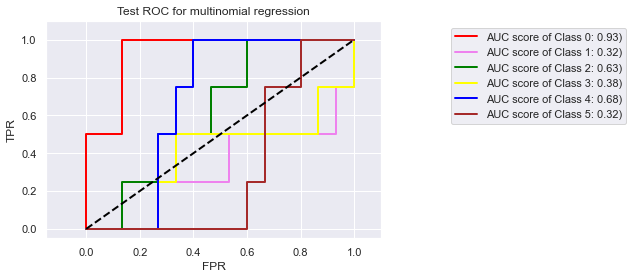

In [27]:
multi_df = multiclass_splitting_function(test_set_links,l_val)
test_X = multi_df.iloc[: , 1:]
test_y = multi_df.iloc[: , 0]
test_X =(test_X-test_X.mean())/test_X.std()
test_X = test_X[best_features]
logistic_regressor = LogisticRegression(penalty="l1", max_iter=25, solver = 'liblinear')
logistic_regressor.fit(test_X, test_y)
test_pred = logistic_regressor.predict(test_X)
pred_test_prob = logistic_regressor.predict_proba(test_X)
accuracy = accuracy_score(test_pred, test_y)
print("Test Accuracy: ", accuracy)
c_matrix_test = confusion_matrix(test_y, test_pred)
print("Confusion Matrix:\n")
print(c_matrix_test)
labels = preprocessing.label_binarize(test_y, classes=[0, 1, 2, 3, 4, 5])
predictions = logistic_regressor.decision_function(test_X)
values = [0,1,2,3,4,5]
FPR = {}
TPR = {}
aucScore = {}
colors = itertools.cycle(['red', 'violet', 'green', 'yellow', 'blue', 'brown'])
location = "lower right"
for i in values:
    FPR[i], TPR[i], temp = roc_curve(labels[:, 0], predictions[:, i])
    aucScore[i] = auc(FPR[i], TPR[i])
for i, j in zip(range(len(values)), colors):
    plt.plot(FPR[i], TPR[i], color = j, linewidth = 2,
             label='AUC score of Class {0}: {1:0.2f})'.format(i, aucScore[i]))  
plt.plot([0, 1], [0, 1], 'k--', linewidth = 2, markersize=12, color='black')
plt.xlim([-0.15, 1.10])
plt.ylim([-0.05, 1.10])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Test ROC for multinomial regression')
plt.legend(loc = location,bbox_to_anchor=(1.75, 0.5))
plt.show()

In [28]:
l_val = 0
best_accuracy = float("-inf")
best_features = []

for l in range(1, 21):
    multi_df = multiclass_splitting_function(train_set_links,l)
    X = multi_df.iloc[: , 1:]
    y = multi_df.iloc[: , 0]
    encode = preprocessing.LabelEncoder()
    encode.fit(y)
    y = encode.transform(y).ravel()
    naive_bayes = GaussianNB()
    naive_bayes.fit(X, y)
    print("-------------------------------------------------------------------------------")
    print("l: ", l)
    predictions = naive_bayes.predict(X)
    accuracy = accuracy_score(predictions, y)
    print("Accuracy : ", accuracy)   
    if best_accuracy < accuracy:
        best_accuracy = accuracy
        l_val = l

-------------------------------------------------------------------------------
l:  1
Accuracy :  0.8405797101449275
-------------------------------------------------------------------------------
l:  2
Accuracy :  0.927536231884058
-------------------------------------------------------------------------------
l:  3
Accuracy :  0.8840579710144928
-------------------------------------------------------------------------------
l:  4
Accuracy :  0.9130434782608695
-------------------------------------------------------------------------------
l:  5
Accuracy :  0.855072463768116
-------------------------------------------------------------------------------
l:  6
Accuracy :  0.8840579710144928
-------------------------------------------------------------------------------
l:  7
Accuracy :  0.8840579710144928
-------------------------------------------------------------------------------
l:  8
Accuracy :  0.855072463768116
-------------------------------------------------------------------

In [29]:
print("Best Score:", best_accuracy)
print("It is achieved at l:", l_val)

Best Score: 0.927536231884058
It is achieved at l: 2


Train Accuracy: 0.927536231884058
Confusion Matrix:

[[ 7  0  1  0  1  0]
 [ 0 12  0  0  0  0]
 [ 0  0 12  0  0  0]
 [ 1  0  1 10  0  0]
 [ 0  0  1  0 11  0]
 [ 0  0  0  0  0 12]]


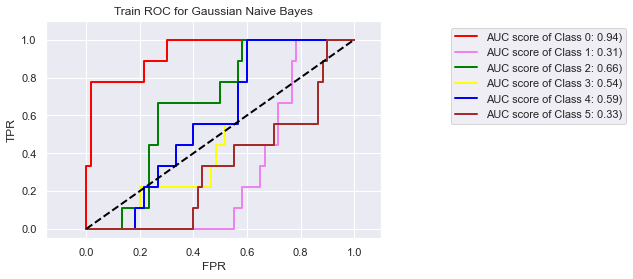

In [30]:
gaussian_res = []
multi_df = multiclass_splitting_function(train_set_links,l_val)
train_X = multi_df.iloc[: , 1:]
train_y = multi_df.iloc[: , 0]
naive_bayes = GaussianNB()
naive_bayes.fit(train_X, train_y)
train_pred = naive_bayes.predict(train_X)
pred_train_prob = naive_bayes.predict_proba(train_X)
accuracy = accuracy_score(train_pred, train_y)
print("Train Accuracy:", accuracy)
c_matrix_train = confusion_matrix(train_y, train_pred)
print("Confusion Matrix:\n")
print(c_matrix_train)
labels = preprocessing.label_binarize(train_y, classes=[0, 1, 2, 3, 4, 5])
predictions = naive_bayes.predict_log_proba(train_X)
values = [0,1,2,3,4,5]
FPR = {}
TPR = {}
aucScore = {}
colors = itertools.cycle(['red', 'violet', 'green', 'yellow', 'blue', 'brown'])
location = "lower right"
for i in values:
    FPR[i], TPR[i], temp = roc_curve(labels[:, 0], predictions[:, i])
    aucScore[i] = auc(FPR[i], TPR[i])
for i, j in zip(range(len(values)), colors):
    plt.plot(FPR[i], TPR[i], color = j, linewidth = 2,
             label='AUC score of Class {0}: {1:0.2f})'.format(i, aucScore[i]))
plt.plot([0, 1], [0, 1], 'k--', linewidth = 2, markersize=12, color='black')
plt.xlim([-0.15, 1.10])
plt.ylim([-0.05, 1.10])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Train ROC for Gaussian Naive Bayes')
plt.legend(loc = location,bbox_to_anchor=(1.75, 0.5))
plt.show()

gaussian_res.append(accuracy)

Test Accuracy: 1.0
Confusion Matrix:

[[4 0 0 0 0 0]
 [0 3 0 0 0 0]
 [0 0 3 0 0 0]
 [0 0 0 3 0 0]
 [0 0 0 0 3 0]
 [0 0 0 0 0 3]]


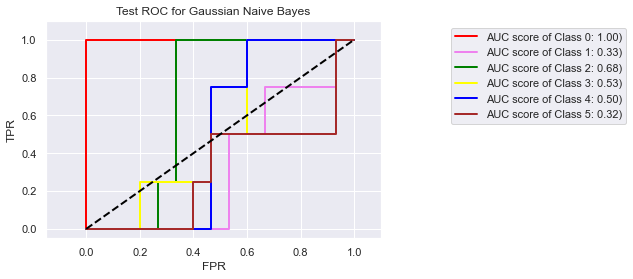

In [31]:
multi_df = multiclass_splitting_function(test_set_links,l_val)
test_X = multi_df.iloc[: , 1:]
test_y = multi_df.iloc[: , 0]
naive_bayes = GaussianNB()
naive_bayes.fit(test_X, test_y)
test_pred = naive_bayes.predict(test_X)
pred_test_prob = naive_bayes.predict_proba(test_X)
accuracy = accuracy_score(test_pred, test_y)
print("Test Accuracy:", accuracy)
c_matrix_test = confusion_matrix(test_y, test_pred)
print("Confusion Matrix:\n")
print(c_matrix_test)
labels = preprocessing.label_binarize(test_y, classes=[0, 1, 2, 3, 4, 5])
predictions = naive_bayes.predict_log_proba(test_X)
values = [0,1,2,3,4,5]
FPR = {}
TPR = {}
aucScore = {}
colors = itertools.cycle(['red', 'violet', 'green', 'yellow', 'blue', 'brown'])
location = "lower right"
for i in values:
    FPR[i], TPR[i], temp = roc_curve(labels[:, 0], predictions[:, i])
    aucScore[i] = auc(FPR[i], TPR[i])
for i, j in zip(range(len(values)), colors):
    plt.plot(FPR[i], TPR[i], color = j, linewidth = 2,
             label='AUC score of Class {0}: {1:0.2f})'.format(i, aucScore[i]))
plt.plot([0, 1], [0, 1], 'k--', linewidth = 2, markersize=12, color='black')
plt.xlim([-0.15, 1.10])
plt.ylim([-0.05, 1.10])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Test ROC for Gaussian Naive Bayes')
plt.legend(loc = location,bbox_to_anchor=(1.75, 0.5))
plt.show()

gaussian_res.append(accuracy)

In [32]:
l_val = 0
best_accuracy = float("-inf")
best_features = []

for l in range(1, 21):
    multi_df = multiclass_splitting_function(train_set_links,l)
    X = multi_df.iloc[: , 1:]
    y = multi_df.iloc[: , 0]
    encode = preprocessing.LabelEncoder()
    encode.fit(y)
    y = encode.transform(y).ravel()
    naive_bayes = MultinomialNB() 
    naive_bayes.fit(X, y)
    print("--------------------------------------------------------------------------")
    print("l: ", l)
    predictions = naive_bayes.predict(X)
    accuracy = accuracy_score(predictions, y)
    print("Accuracy : ", accuracy)       
    if best_accuracy < accuracy:
        best_accuracy = accuracy
        l_val = l  

--------------------------------------------------------------------------
l:  1
Accuracy :  0.6376811594202898
--------------------------------------------------------------------------
l:  2
Accuracy :  0.6811594202898551
--------------------------------------------------------------------------
l:  3
Accuracy :  0.6666666666666666
--------------------------------------------------------------------------
l:  4
Accuracy :  0.7246376811594203
--------------------------------------------------------------------------
l:  5
Accuracy :  0.6956521739130435
--------------------------------------------------------------------------
l:  6
Accuracy :  0.7391304347826086
--------------------------------------------------------------------------
l:  7
Accuracy :  0.7391304347826086
--------------------------------------------------------------------------
l:  8
Accuracy :  0.7391304347826086
--------------------------------------------------------------------------
l:  9
Accuracy :  0.782608695

In [33]:
print("Best Score:", best_accuracy)
print("It is achieved at l:", l_val)

Best Score: 0.8115942028985508
It is achieved at l: 11


Train Accuracy: 0.8115942028985508
Confusion Matrix:

[[ 5  0  1  1  2  0]
 [ 0 12  0  0  0  0]
 [ 0  0 10  0  2  0]
 [ 0  0  5  6  1  0]
 [ 0  0  1  0 11  0]
 [ 0  0  0  0  0 12]]


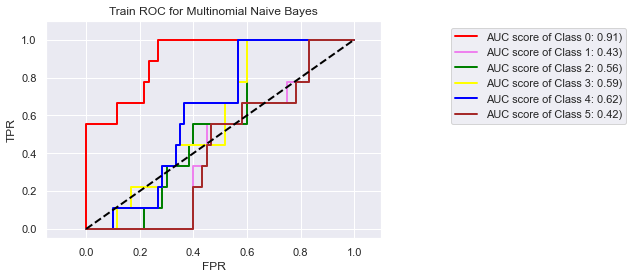

In [34]:
multinomial_res = []
multi_df = multiclass_splitting_function(train_set_links,l_val)
train_X = multi_df.iloc[: , 1:]
train_y = multi_df.iloc[: , 0]
naive_bayes = MultinomialNB()
naive_bayes.fit(train_X, train_y)
train_pred = naive_bayes.predict(train_X)
pred_train_prob = naive_bayes.predict_proba(train_X)
accuracy = accuracy_score(train_pred, train_y)
print("Train Accuracy:", accuracy)
c_matrix_train = confusion_matrix(train_y, train_pred)
print("Confusion Matrix:\n")
print(c_matrix_train)
labels = preprocessing.label_binarize(train_y, classes=[0, 1, 2, 3, 4, 5])
predictions = naive_bayes.predict_log_proba(train_X)
values = [0,1,2,3,4,5]
FPR = {}
TPR = {}
aucScore = {}
colors = itertools.cycle(['red', 'violet', 'green', 'yellow', 'blue', 'brown'])
location = "lower right"
for i in values:
    FPR[i], TPR[i], temp = roc_curve(labels[:, 0], predictions[:, i])
    aucScore[i] = auc(FPR[i], TPR[i])
for i, j in zip(range(len(values)), colors):
    plt.plot(FPR[i], TPR[i], color = j, linewidth = 2,
             label='AUC score of Class {0}: {1:0.2f})'.format(i, aucScore[i]))
plt.plot([0, 1], [0, 1], 'k--', linewidth = 2, markersize=12, color='black')
plt.xlim([-0.15, 1.10])
plt.ylim([-0.05, 1.10])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Train ROC for Multinomial Naive Bayes')
plt.legend(loc = location,bbox_to_anchor=(1.75, 0.5))
plt.show()

multinomial_res.append(accuracy)

Test Accuracy :  0.8421052631578947
Confusion Matrix:

[[2 0 0 2 0 0]
 [0 3 0 0 0 0]
 [0 0 2 0 1 0]
 [0 0 0 3 0 0]
 [0 0 0 0 3 0]
 [0 0 0 0 0 3]]


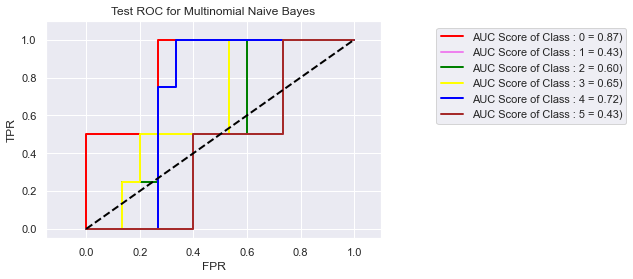

In [35]:
multi_df = multiclass_splitting_function(test_set_links,l_val)
test_X = multi_df.iloc[: , 1:]
test_y = multi_df.iloc[: , 0]
naive_bayes = MultinomialNB() 
naive_bayes.fit(test_X, test_y)
test_pred = naive_bayes.predict(test_X)
pred_test_prob = naive_bayes.predict_proba(test_X)
accuracy = accuracy_score(test_pred, test_y)
print("Test Accuracy : ", accuracy)
confusionMatrixTestDataset = confusion_matrix(test_y, test_pred)
print("Confusion Matrix:\n")
print(confusionMatrixTestDataset)
labels = preprocessing.label_binarize(test_y, classes=[0, 1, 2, 3, 4, 5])
predictions = naive_bayes.predict_log_proba(test_X)
values = [0,1,2,3,4,5]
FPR = {}
TPR = {}
aucScore = {}
colors = itertools.cycle(['red', 'violet', 'green', 'yellow', 'blue', 'brown'])
location = "lower right"
for i in values:
    FPR[i], TPR[i], temp = roc_curve(labels[:, 0], predictions[:, i])
    aucScore[i] = auc(FPR[i], TPR[i])  
for i, j in zip(range(len(values)), colors):
    plt.plot(FPR[i], TPR[i], color = j, linewidth = 2,
             label='AUC Score of Class : {0} = {1:0.2f})'.format(i, aucScore[i]))
plt.plot([0, 1], [0, 1], 'k--', linewidth = 2, markersize=12, color='black')
plt.xlim([-0.15, 1.10])
plt.ylim([-0.05, 1.10])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Test ROC for Multinomial Naive Bayes')
plt.legend(loc = location,bbox_to_anchor=(1.75, 0.5))
plt.show()

multinomial_res.append(accuracy)

In [36]:
dictionary = {}
dictionary['Gaussian NB'] = gaussian_res
dictionary['Multinomial NB'] = multinomial_res

res = pd.DataFrame(dictionary, index = ['Train accuracy', 'Test accuracy'])
res

,Gaussian NB,Multinomial NB
Train accuracy,0.927536,0.811594
Test accuracy,1.000000,0.842105


#### Gaussian Naive Bayes is better than others for this problem